# 2d, 3 datasets example
- applies TreeDSBM on the three datasets example from Noble et al., 2023

In [1]:
import os  # before importing anything jax

# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
os.environ['CUDA_VISIBLE_DEVICES']='4'

import sys
sys.path.append("..")

import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from functools import partial
from omegaconf import OmegaConf

from models import ScoreMLP, BasicModel
from run_BarycentreDSBM import BarycentreDSBM

## plotting fns

In [2]:
def plot_trajectory(traj, start=None, end=None, alpha=1.0):
    """
    Plots a single trajectory given an (n, 2) array of points.

    Parameters:
    - traj: np.ndarray of shape (n, 2), representing the trajectory.
    - start: Optional tuple (x, y) for the start point.
    - end: Optional tuple (x, y) for the end point.
    - alpha: Transparency level for the trajectory.
    """
    plt.plot(traj[:, 0], traj[:, 1], label='Trajectory', alpha=alpha * 0.2)

    if start is not None:
        plt.scatter(*start, color='green', s=100, label='Start', edgecolors='black', alpha=alpha)
    
    if end is not None:
        plt.scatter(*end, color='red', s=100, label='End', edgecolors='black', alpha=alpha)

def plot_multiple_trajectories(trajs, alpha=0.5):
    """
    Plots multiple trajectories given a (B, N, 2) array of points.

    Parameters:
    - trajs: np.ndarray of shape (B, N, 2), where B is the number of trajectories.
    - alpha: Transparency level to visualize overlapping trajectories.
    """
    trajs = jnp.asarray(trajs)
    B = trajs.shape[0]

    plt.figure(figsize=(8, 6))

    for i in range(B):
        start, end = trajs[i, 0], trajs[i, -1]
        plot_trajectory(trajs[i], start=start, end=end, alpha=alpha)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(['Trajectory', 'Start', 'End'])
    plt.grid(True)
    plt.axis('equal')
    plt.show()


def plot_coupling(x0, x1, alpha=0.5):
    """
    Plots lines connecting pairs of points from x0 to x1.

    Parameters:
    - x0: np.ndarray of shape (B, 2), starting points.
    - x1: np.ndarray of shape (B, 2), ending points.
    - alpha: Transparency level.
    """
    B = x0.shape[0]

    plt.figure(figsize=(8, 6))

    for i in range(B):
        plt.plot([x0[i, 0], x1[i, 0]], [x0[i, 1], x1[i, 1]], 'b-', alpha=alpha*0.2)

    plt.scatter(x0[:, 0], x0[:, 1], color='green', s=100, label='Start', edgecolors='black', alpha=alpha)
    plt.scatter(x1[:, 0], x1[:, 1], color='red', s=100, label='End', edgecolors='black', alpha=alpha)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

## define distributions

In [3]:
# get the adjustment factors used in the Noble et al code (for easy comparison)
import numpy as np
from sklearn import datasets

X, _ = datasets.make_moons(n_samples=10000, noise=0.0)
X = jnp.array(X)
moon_mean = X.mean()
moon_std = X.std()

X, _ = datasets.make_circles(n_samples=10000, noise=0.0, factor=0.5)
X = jnp.array(X)
circles_mean = X.mean()
circles_std = X.std()

X, _ = datasets.make_swiss_roll(n_samples=10000, noise=0.0)
X = jnp.array(X)[:,[0,2]]
swiss_roll_mean = X.mean()
swiss_roll_std = X.std()

class Moon:
    def __init__(self, noise=0.0, scaling_factor=1.0):
        self.noise = noise
        self.scaling_factor = scaling_factor

    @partial(jax.jit, static_argnums=(0,2))
    def sample(self, key, num_samples):
        key1, key2, key3 = jax.random.split(key, 3)
        n1 = num_samples // 2
        n2 = num_samples - n1

        theta1 = jnp.pi * jax.random.uniform(key1, shape=(n1,))
        x1 = jnp.stack([jnp.cos(theta1), jnp.sin(theta1)], axis=-1)

        theta2 = jnp.pi * jax.random.uniform(key2, shape=(n2,))
        x2 = jnp.stack([1.0 - jnp.cos(theta2), 1.0 - jnp.sin(theta2) - 0.5], axis=-1)

        x = jnp.concatenate([x1, x2], axis=0)

        # Normalize the data
        x = (x - moon_mean) / moon_std * self.scaling_factor

        if self.noise > 0.0:
            x += self.noise * jax.random.normal(key3, shape=x.shape)
        return x

class Circle:
    def __init__(self, noise=0.0, factor=0.5, scaling_factor=1.0):
        self.noise = noise
        self.factor = factor
        self.scaling_factor = scaling_factor

    @partial(jax.jit, static_argnums=(0,2))
    def sample(self, key, num_samples):
        key1, key2, key3 = jax.random.split(key, 3)
        n1 = num_samples // 2
        n2 = num_samples - n1

        theta1 = 2 * jnp.pi * jax.random.uniform(key1, shape=(n1,))
        x1 = jnp.stack([jnp.cos(theta1), jnp.sin(theta1)], axis=-1)

        theta2 = 2 * jnp.pi * jax.random.uniform(key2, shape=(n2,))
        x2 = self.factor * jnp.stack([jnp.cos(theta2), jnp.sin(theta2)], axis=-1)

        x = jnp.concatenate([x1, x2], axis=0)

        # Normalize the data
        x = (x - circles_mean) / circles_std * self.scaling_factor

        if self.noise > 0.0:
            x += self.noise * jax.random.normal(key3, shape=x.shape)
        return x

class SwissRoll:
    def __init__(self, noise=0.0, scaling_factor=1.0):
        self.noise = noise
        self.scaling_factor = scaling_factor

    @partial(jax.jit, static_argnums=(0,2))
    def sample(self, key, num_samples):
        key1, key2, key3 = jax.random.split(key, 3)
        t = 1.5 * jnp.pi * (1 + 2 * jax.random.uniform(key1, shape=(num_samples,)))
        y = 21 * jax.random.uniform(key2, shape=(num_samples,))
        x = t * jnp.cos(t)
        z = t * jnp.sin(t)

        data = jnp.stack([x, y, z], axis=-1)

        x = data[:, [0, 2]]
        # Normalize the data
        x = (x - swiss_roll_mean) / swiss_roll_std * self.scaling_factor

        if self.noise > 0.0:
            x += self.noise * jax.random.normal(key3, shape=x.shape)
        return x

## define the problem, model

In [4]:
shape = (2,)

epsilon = 0.1
sigma = jnp.sqrt(epsilon / 2)   # convert from epsilon to sigma

# define the fixed marginals
scaling_factor = 7.0
std = 0.0
mu_0 = Moon(scaling_factor=scaling_factor, noise=std)
mu_1 = Circle(scaling_factor=scaling_factor, noise=std)
mu_2 = SwissRoll(scaling_factor=scaling_factor, noise=std)

mu_lst = [mu_0, mu_1, mu_2]
weights = jnp.array([1.0, 1.0, 1.0])
weights = weights / jnp.sum(weights)

model = BasicModel(out_dim=shape[0], d=2)

## training

In [5]:
baryDSBM = BarycentreDSBM(
    mu_lst=mu_lst,
    sigma=sigma,
    shape=shape,
    model=model,
)

train_config = OmegaConf.create({
    'num_IMF_steps': 4,
    'num_sampling_steps': 100,
    'num_training_steps': 10_000,
    'reflow_num_training_steps': None, # number of training steps for reflow (could be lower if desired)
    'num_training_samples': 8192,  # number of samples to simulate for subsequent IMF iterations
    'lr': 1e-3,
    'batch_size': 4096,
    'simulation_batch_size': None, # if num_training_samples is too large, set this to be smaller to simulate in batches
    'ema_rate': 0.01,
    'simultaneous_training': True, # True, False,
    'warmstart': False, # True, False, # whether to warmstart the model with the params from the first iteration
})

key = jax.random.PRNGKey(0)
all_states_lst, all_bms_lst = baryDSBM.train(key, train_config=train_config, model=model)

Running IMF step 1


Training: 100%|██████████| 10000/10000 [01:19<00:00, 126.31step/s, loss=37.6]


Running IMF step 2


Training: 100%|██████████| 10000/10000 [01:11<00:00, 139.66step/s, loss=6.17]


Running IMF step 3


Training: 100%|██████████| 10000/10000 [01:06<00:00, 150.16step/s, loss=4.84]


Running IMF step 4


Training: 100%|██████████| 10000/10000 [01:06<00:00, 150.11step/s, loss=5.37]


## visualising the results

- first, look at the obtained marginals and the barycentre

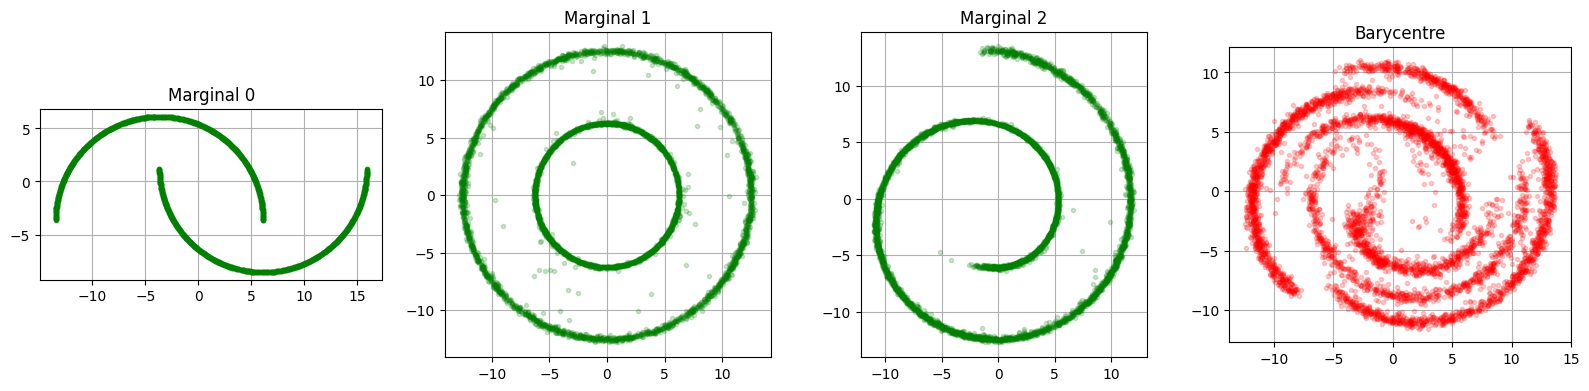

In [6]:
key = jax.random.PRNGKey(0)
num_steps = 50
num_samples = 5000

start_idx = 0

IMF_idx = -1

bm_lst = all_bms_lst[IMF_idx]
states_lst = all_states_lst[IMF_idx]

coupling_samples, trajs = baryDSBM.get_multi_coupling(key, bm_lst, states_lst, num_steps=num_steps, num_samples=num_samples, start_idx=start_idx, return_trajs=True)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))  # 1 row, 4 columns
for i in range(4):
    ys = coupling_samples[i, :, :]
    color = 'g.' if i < 3 else 'r.'
    axes[i].plot(ys[:, 0], ys[:, 1], color, alpha=0.2)
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].grid(True)
    if i < 3:
        axes[i].set_title(f"Marginal {i}")
    else:
        axes[i].set_title("Barycentre")

plt.tight_layout()
plt.show()


- evaluating Sinkhorn divergence to the ground truth

In [7]:
import ott
from ott.tools.sinkhorn_divergence import sinkdiv

bary_samples = coupling_samples[-1, :, :]
sink_div_eps = 0.01

ground_truth_samples = jnp.load('../2d_3datasets_arrays/2d_free_support_exact_barycenter.npy')

sink_div, _ = sinkdiv(
        ground_truth_samples,
        bary_samples,
        epsilon=sink_div_eps,
        )

print(f'Sinkhorn divergence: {sink_div:.4f}')

Sinkhorn divergence: 1.1483


In [8]:
sink_div_eps = 0.01
num_samples = 5000
num_steps = 100

def get_sinkdiv_along_edge(key, state, bm):

    drift_fn = bm.get_drift_fn(state, use_ema_params=True, fwd=True)
    _, nu_samples = bm.sample(key, drift_fn, num_samples, num_steps, fwd=True)

    sink_div, _ = sinkdiv(
        ground_truth_samples,
        nu_samples,
        epsilon=sink_div_eps,
        )
    
    return sink_div

def get_sink_divs_from_run(key, states_lst, bm_lst):

    sink_divs = []
    for i in range(len(states_lst)):
        state = states_lst[i]
        bm = bm_lst[i]
        sink_div = get_sinkdiv_along_edge(key, state, bm)
        sink_divs.append(sink_div)
    return jnp.array(sink_divs)

In [9]:
key = jax.random.PRNGKey(0)

IMF_idx = -1  # use the last IMF
states_lst = all_states_lst[IMF_idx]
bm_lst = all_bms_lst[IMF_idx]

sink_divs = get_sink_divs_from_run(key, states_lst, bm_lst)
print("Sinkhorn divergences along the edges:", sink_divs)
print("Average Sinkhorn divergence:", jnp.mean(sink_divs))

Sinkhorn divergences along the edges: [1.1557144 1.1586741 1.0598016]
Average Sinkhorn divergence: 1.1247301


- and to visualise along one of the edges:

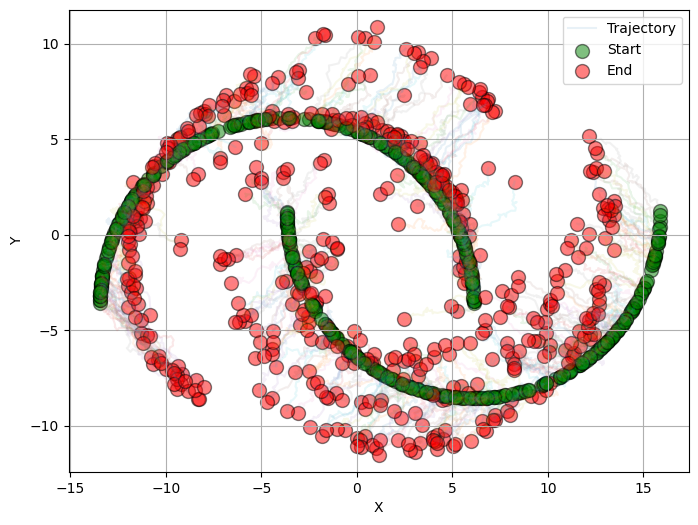

In [10]:
num_samples = 512
num_steps = 50

edge_idx = 0
IMF_idx = -1

edge_bm = all_bms_lst[IMF_idx][edge_idx]
edge_state = all_states_lst[IMF_idx][edge_idx]
drift_fn = edge_bm.get_drift_fn(edge_state, use_ema_params=True, fwd=True)

key = jax.random.PRNGKey(0)
trajs, ys = bm_lst[edge_idx].sample(key, drift_fn, num_samples, num_steps, fwd=True)

plot_multiple_trajectories(trajs, alpha=0.5)